# Titanic - Machine Learning from disaster
###Whitney Brummet
###CSCI 191

##Dataset From Competition

In [133]:
#importing dataset
import pandas as pd

train = pd.read_csv("/content/sample_data/train.csv")
test = pd.read_csv("/content/sample_data/test.csv")

In [134]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [135]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


##Reworking Dataset

In [136]:
#imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set()

In [137]:
#changing features into numerical values as well as filling in missing data

train_test_data = [train, test]

##Name
#Change name to title
for dataset in train_test_data:
  dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3, "Countess": 3, 
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona": 3, "Mme": 3, "Capt": 3, "Sir": 3 }

for dataset in train_test_data:
  dataset['Title'] = dataset['Title'].map(title_mapping)

train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

##Sex
sex_mapping = {"male": 0, "female": 1}
for dataset in train_test_data:
  dataset['Sex'] = dataset['Sex'].map(sex_mapping)

##age
for dataset in train_test_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 62, 'Age'] = 4
    
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)

##embarked
for dataset in train_test_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')

embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in train_test_data:
  dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

##fare
train["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace=True)
test["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace=True)

for dataset in train_test_data:
  dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2
  dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3

##cabin
for dataset in train_test_data:
  dataset['Cabin'] = dataset['Cabin'].str[:1]

cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
for dataset in train_test_data:
  dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
test["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

##family
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
for dataset in train_test_data:
  dataset['FamilySize'] = dataset['FamilySize'].map(family_mapping)

##feature drop
features_drop = ['Ticket', 'SibSp', 'Parch']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(["PassengerId"], axis=1)

train_data = train.drop('Survived', axis=1)
target = train['Survived']

train_data.shape, target.shape

((891, 8), (891,))

In [138]:
train_data.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,1.0,0.0,2.0,0,0,0.4
1,1,1,3.0,2.0,0.8,1,2,0.4
2,3,1,1.0,0.0,2.0,0,1,0.0
3,1,1,2.0,2.0,0.8,0,2,0.4
4,3,0,2.0,0.0,2.0,0,0,0.0


In [139]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,0,2.0,0.0,2.0,2,0,0.0
1,893,3,1,3.0,0.0,0.8,0,2,0.4
2,894,2,0,3.0,0.0,2.0,2,0,0.0
3,895,3,0,2.0,0.0,0.8,0,0,0.0
4,896,3,1,1.0,0.0,2.0,0,2,0.8


##Visuals

In [140]:
#function to set up bar charts
def bar_chart(feature):
  survived = train[train['Survived'] ==1][feature].value_counts()
  dead = train[train['Survived']==0][feature].value_counts()
  df = pd.DataFrame([survived, dead])
  df.index = ['Survived', 'Dead']
  df.plot(kind='bar', stacked=True, figsize=(10,5))

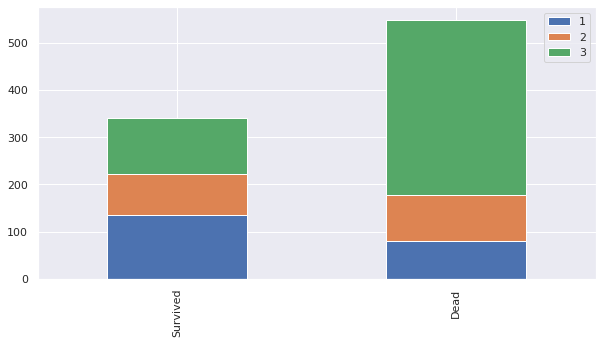

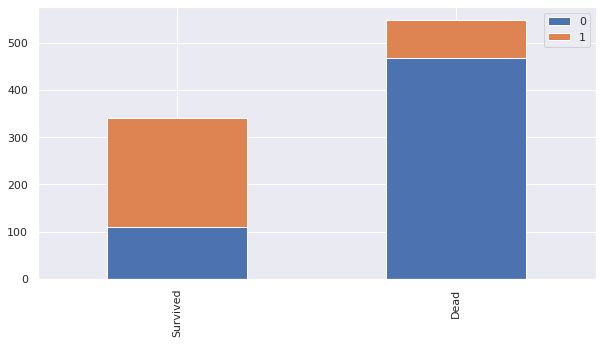

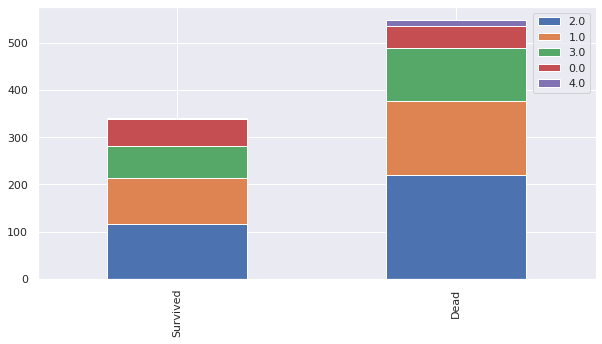

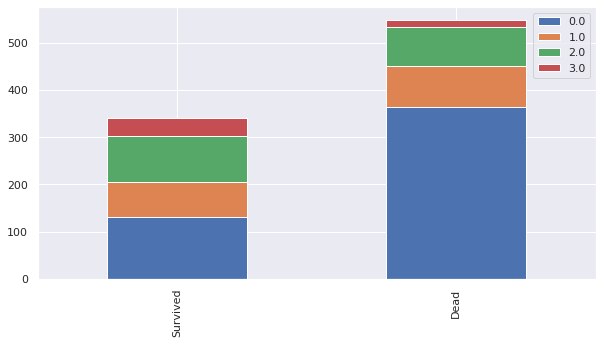

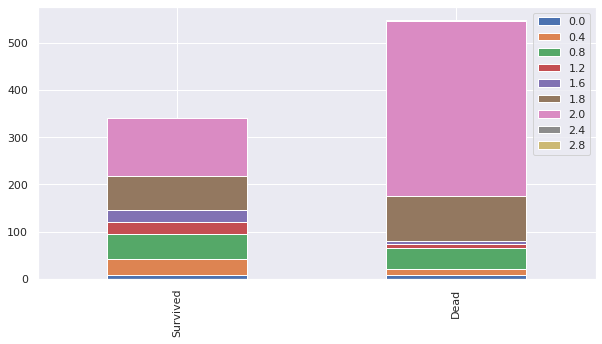

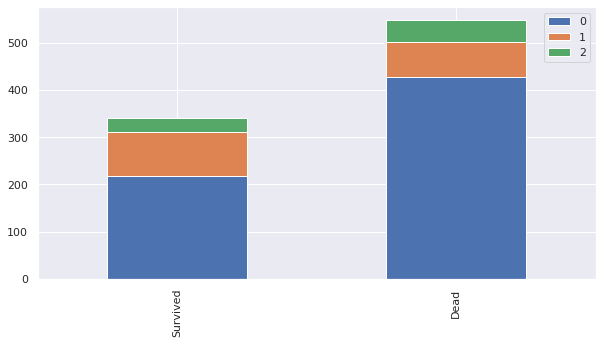

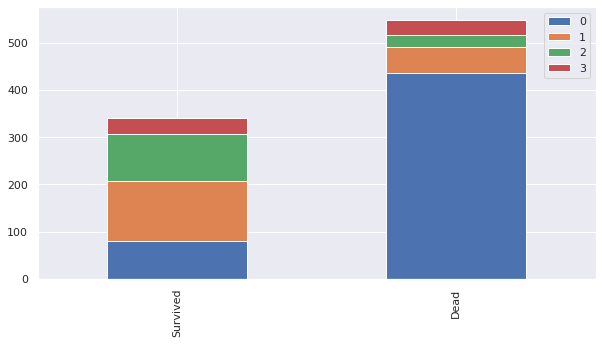

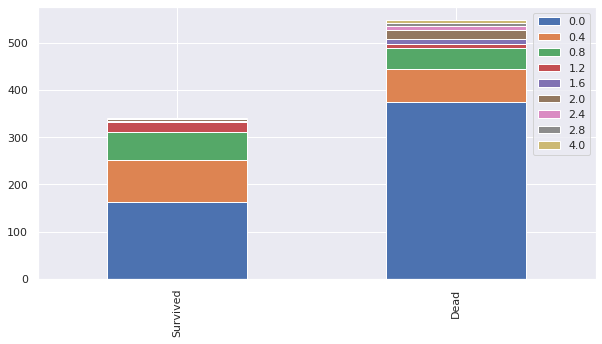

In [141]:
#bar charts to determine features
bar_chart('Pclass')
bar_chart('Sex')
bar_chart('Age')
bar_chart('Fare')
bar_chart('Cabin')
bar_chart('Embarked')
bar_chart('Title')
bar_chart('FamilySize')

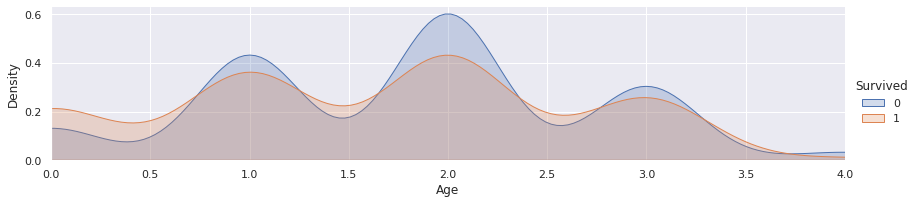

In [142]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.show()

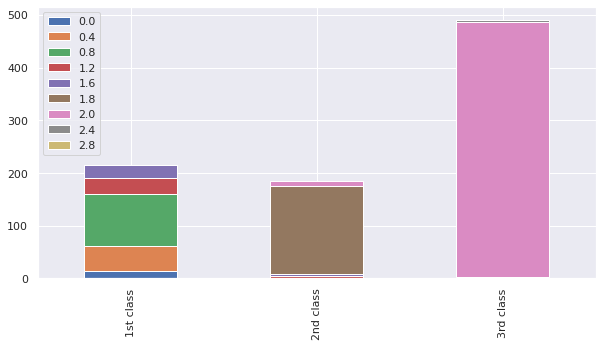

In [143]:
Pclass1 = train[train['Pclass']==1]['Cabin'].value_counts()
Pclass2 = train[train['Pclass']==2]['Cabin'].value_counts()
Pclass3 = train[train['Pclass']==3]['Cabin'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(10,5))

(0.0, 4.0)

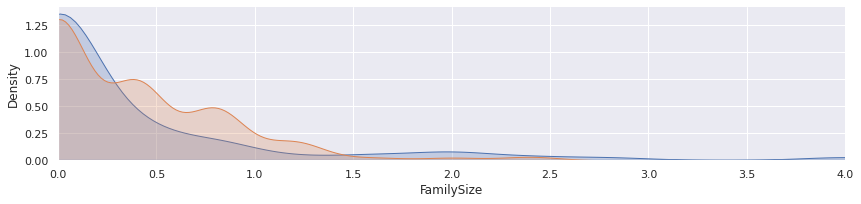

In [144]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)
facet.map(sns.kdeplot, 'FamilySize', shade=True)
facet.set(xlim=(0, train['FamilySize'].max()))
plt.xlim(0)

##Model

In [145]:
#imports
import math
import numpy as np
import random
import plotly.express as px
import sklearn
from sklearn.metrics import accuracy_score
import pandas as pd



##functions
def F(W,X):
  return sum([w*x for w,x in zip(W,X)])

def sigmoid(x):
  return 1.0/(1+math.exp(-x))

def predict(model, x):
  w1 = model[0]
  w2 = model[1]
  v1 = model[2]
  z1 = sigmoid(F(w1, x))
  z2 = sigmoid(F(w2, x))
  Z = (1, z1, z2)
  y = sigmoid(F(v1,Z))
  return y
  
def classify(Y):
  return [1 if y > 0.5 else 0 for y in Y]



##translating dataset features into lists
x1 = []
x2 = []
R = []

for x in train_data.index:
  x1.append(train_data['Pclass'][x])
  x2.append(train_data['Sex'][x])
  R.append(target[x])

X = [(1, x1, x2) for x1,x2 in zip(x1,x2)]

data = [((x1, x2), R) for x1,x2,R in zip(x1, x2, R)]



##function to assign random weights
np.random.seed(42)
def randomWeights(weightVectors, range):
  newWeightVectors = []
  for weightVector in weightVectors:
    newWeightVectors.append([np.random.uniform(-1*range, range) for w in weightVector])
  return newWeightVectors

##intial weights
w1 = [0, 0, 0]
w2 = [0, 0, 0]
v1 = [0, 0, 0]
[w1, w2, v1] = randomWeights([w1, w2, v1], 0.1)
model = [w1, w2, v1]
print("First Model:", model)



alpha = 0.3

trainingData = [((1, x1, x2), r) for ((x1, x2), r) in data]
print("Training Data:", trainingData)



##function for backpropagation
def Backpropagation(model, learningRate, data, iterations):
  w1 = model[0]
  w2 = model[1]
  v1 = model[2]
  for i in range(iterations):
    
    # Tracking Squared Error and Accuracy (every 100 iterations)      
    if (i % 100) == 0:
      R1 = []
      x1 = []
      x2 = []
      for x in test.index:
        x1.append(test['Pclass'][x])
        x2.append(test['Sex'][x])
        R1.append(target[x])
  
      testData = [((x1, x2), R1) for x1,x2,R1 in zip(x1, x2, R1)]
      X = [(1, x1, x2) for ((x1, x2),r) in testData]
      R = [r for ((x1, x2),r) in testData]
      yPred = [predict([w1, w2, v1], x) for x in X]
      squaredError = sum([pow(r - y, 2) for (r, y) in zip(R, yPred)])
  
      classPred = classify(yPred)
      accuracy = sklearn.metrics.accuracy_score(R, classPred)

    # Backpropagation
    for (x, r) in data:
      # Forward Pass
      z1 = sigmoid(F(w1, x))
      z2 = sigmoid(F(w2, x))
      Z = (1, z1, z2)
      y = sigmoid(F(v1,Z))

      # Backward Pass
      deltaV = [learningRate * (r - y) * z for z in Z]
      deltaW1 = [learningRate * (r - y) * v1[1] * z1 * (1 - z1) * xi for xi in x]
      deltaW2 = [learningRate * (r - y) * v1[2] * z2 * (1 - z2) * xi for xi in x]

      v1 = [v + dv for (v, dv) in zip(v1, deltaV)]
      w1 = [w + dw for (w, dw) in zip(w1, deltaW1)]
      w2 = [w + dw for (w, dw) in zip(w2, deltaW2)]

  newModel = [w1, w2, v1]
  return newModel



#performing backpropagation function
model = Backpropagation(model, alpha, trainingData, 1000)
print("Final Model:", model)

xF1 = []
xF2 = []

for x in train_data.index:
    xF1.append(train_data['Pclass'][x])
    xF2.append(train_data['Sex'][x])

X = [(1, xF1, xF2) for xF1,xF2 in zip(xF1,xF2)]

yPred = [predict(model, x) for x in X]
print("Y Predictions:", yPred)
print("Class Predictions:", classify(yPred))
print("Accuracy:", sklearn.metrics.accuracy_score(R, classifyY(yPred)))

First Model: [[-0.025091976230527502, 0.09014286128198323, 0.04639878836228101], [0.019731696839407314, -0.0687962719115127, -0.06880109593275947], [-0.08838327756636011, 0.07323522915498704, 0.020223002348641758]]
Training Data: [((1, 3, 0), 0), ((1, 1, 1), 1), ((1, 3, 1), 1), ((1, 1, 1), 1), ((1, 3, 0), 0), ((1, 3, 0), 0), ((1, 1, 0), 0), ((1, 3, 0), 0), ((1, 3, 1), 1), ((1, 2, 1), 1), ((1, 3, 1), 1), ((1, 1, 1), 1), ((1, 3, 0), 0), ((1, 3, 0), 0), ((1, 3, 1), 0), ((1, 2, 1), 1), ((1, 3, 0), 0), ((1, 2, 0), 1), ((1, 3, 1), 0), ((1, 3, 1), 1), ((1, 2, 0), 0), ((1, 2, 0), 1), ((1, 3, 1), 1), ((1, 1, 0), 1), ((1, 3, 1), 0), ((1, 3, 1), 1), ((1, 3, 0), 0), ((1, 1, 0), 0), ((1, 3, 1), 1), ((1, 3, 0), 0), ((1, 1, 0), 0), ((1, 1, 1), 1), ((1, 3, 1), 1), ((1, 2, 0), 0), ((1, 1, 0), 0), ((1, 1, 0), 0), ((1, 3, 0), 1), ((1, 3, 0), 0), ((1, 3, 1), 0), ((1, 3, 1), 1), ((1, 3, 1), 0), ((1, 2, 1), 0), ((1, 3, 0), 0), ((1, 2, 1), 1), ((1, 3, 1), 1), ((1, 3, 0), 0), ((1, 3, 0), 0), ((1, 3, 1), 1), (